先前准备，上传此数据集 :https://www.kaggle.com/c/GiveMeSomeCredit/data

# 一 、 用逻辑回归制作评分卡 with sklearn

+ 参考： https://www.kesci.com/mw/project/5edaf51ab772f5002d6ed9d4
+ https://colab.research.google.com/drive/11vwy8q_1fVGl0BANL7co01HrLaF369dl?usp=sharing

**其他模型及资源**
+ 反欺诈模型+数据集(和鲸社区)：https://www.kesci.com/mw/project/5f3b92b3af3980002cbea90e
+ 风控日常数据集(和鲸社区)：https://www.kesci.com/mw/dataset/5ff17115840381003b005800/file
+ 拍拍贷风控算法大赛数据集(和鲸社区)：https://www.kesci.com/mw/dataset/5eb6ace3366f4d002d77e823/file
+ 风控算法大赛：https://www.kesci.com/home/competition/forumlist/56cd5f02b89b5bd026cb39c9
+ 信贷申请评分卡：https://www.kesci.com/mw/project/5c832af77ea30f002b25f8b9/content
+ 银行信贷申请评分卡(逻辑回归): https://www.kesci.com/mw/project/5edaf51ab772f5002d6ed9d4/content

在银行借贷场景中，评分卡是以分数形式来衡量一个客户信用风险大小的手段，它衡量想向别人借钱的人如果不能
如期履行合同中的还本付息责任，并让借钱给别人的人造成经济损失的可能性。一般来说，评分卡打出的分数越高，
客户的信用越好，风险越小。

借钱的实体可能是指个人，也可能是指公司和企业。对于企业来说，按照融资企业的融资用途分别使用企业融资模型、现金流融资模型、项目融资模型等模型。而对于个人来说，我们有四张卡来评估个人的信用程度：A卡、B卡、C卡、F卡。A卡被称为申请评分卡或者申请者评级模型，用来帮助金融机构来判断是否应该借钱给一个新用户。如果某一个人风险太高，我们就可以拒绝贷款

## 1.理解数据

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression 
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv(r"../input/GiveMeSomeCredit/cs-training.csv",index_col=0)
data.head()

+ 每一个字段的含义：

|  字段	|字段的含义  |
|  ----  | ----  |
|  SeriousDlqin2yrs | 出现90天或更长时间的逾期行为 |
|  RevolvingUtilizationOfUnsecuredLines | 信用卡和个人可用额度的总和与信用限额之比 |
|age	|借款人年龄|
|NumberOfTime30-59DaysPastDueNotWorse|	近两年内出现逾期35-59天的次数|
|DebtRatio	|每月偿还债务，赡养费，生活费用除以当月总收入|
|MonthlyIncome	|月收入|
|NumberOfOpenCreditLinesAndLoans	|未偿还的贷款或信用额度的数量|
|NumberOfTimes90DaysLate|	近两年内出现90天逾期或更坏的次数|
|NumberRealEstateLoansOrLines	|抵押贷款和房地产贷款数量，包括房屋净值信贷额度|
|NumberOfTime60-89DaysPastDueNotWorse	|近两年内出现60-89天逾期的次数|
|NumberOfDependents	|家庭中不包括自身的家属人数（配偶、子女等）|

## 2.数据预处理

### 2.1 查看数据简要情况

In [ ]:
# 查看形状
data.shape

In [ ]:
# 查看数据集中每个字段的信息
data.info()

In [ ]:
# 查看缺失值、异常值（最大最小）、分布情况。
data.describe()

### 2.2 重复值处理

In [ ]:
# 检查数据中重复值的存在情况
data.duplicated().sum()

In [ ]:
# 过滤重复值 inplace=True ，直接对原对象修改。
# data.drop_duplicates(inplace=True)
data = data.drop_duplicates()
# 检查过滤效果
data.duplicated().sum()

In [ ]:
# 删除重复值后，需要重新恢复索引
data.index = range(data.shape[0])

# 最后在检查一下数据的信息，看看索引有没有正确恢复
data.info()

### 2.3 缺失值处理

In [ ]:
# 检查数据集中每一个字段的数据缺失情况
data.isnull().sum()

In [ ]:
data.isnull().sum()/data.shape[0]

从上面可以看到，**MonthlyIncome**和**NumberOfDependents**这两个字段存在缺失值。

**NumberOfDependents**字段的缺失率较小，大概只有**2.5%**，可以考虑之间删除或者用均值来填补。

**MonthlyIncome**字段缺失了几乎**20%**，并且收入对于信用评分来讲是一个很重要的因素，这个特征必须要填补。
对于银行数据，我们可以有这样的推断：高收入或者稳定收入对于申请贷款是很有帮助的。如果是一个收入稳定良好的人，肯定会倾向于写上自己的收入情况，那么这些收入字段缺失的人，更可能是收入状况不稳定或者收入比较低的人。所以，我们可以采用四分位数来填补缺失值，把所有收入字段为空的客户都当成低收入群体。当然，也有可能这些缺失是银行数据收集过程中的失误导致的。具体采用什么样的手段来填补缺失值，要和业务人员沟通，观察缺失值是如何产生的。在这里，我们采用**随机森林**来填补缺失值。

In [ ]:
# 可以使用均值来填补NumberOfDependents字段的缺失值
# a = data['NumberOfDependents'].mean()
# data['NumberOfDependents'].fillna(a,inplace=True)

In [ ]:
# 查看数据情况，选用已知列[0,1,2,3,4,6,7,8,9] 来预测 [5] 和 [10]
data.info()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def fill_data(data_df,col_name,target_col):
  known = data_df[data_df[col_name].notnull()]
  unknown = data_df[data_df[col_name].isnull()]

  x_train = known.iloc[:,[0,1,2,3,4,6,7,8,9]]
  y_train = known.iloc[:,target_col]

  x_test = unknown.iloc[:,[0,1,2,3,4,6,7,8,9]]

  # 学习器太大比较慢
  clf = RandomForestRegressor(n_estimators=10,random_state=0)

  pred = clf.fit(x_train,y_train)
  pred = clf.predict(x_test)
  return pred

# 生成缺失值
pred_MonthlyIncome = fill_data(data,'MonthlyIncome',5)
pred_NumberOfDependents = fill_data(data,'NumberOfDependents',10)

# 填充缺失值 MonthlyIncome  NumberOfDependents
data.loc[data['MonthlyIncome'].isnull(),'MonthlyIncome'] = pred_MonthlyIncome
data.loc[data['NumberOfDependents'].isnull(),'NumberOfDependents'] = pred_NumberOfDependents

#再次检查缺失值的情况
data.info()

### 2.4 利用描述性统计来处理异常值

现实数据中总是存在一些异常值，我们要把这些异常值捕捉出来，然后观察他们的性质。有时候，我们可能是要将这些异常值去除，而有些时候异常值则是我们的重点研究对象。

日常处理异常值，往往使用箱型图或者3sigma法则来寻找异常值。

具体到银行数据中，在特征量有限的情况下，我们往往使用描述性统计方法来观察数据的异常以及数据的分布情况。

In [ ]:
# 描述性统计
data.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

通过仔细观察**age**可能存在一些异常值，它的最小值为0。一般能够在银行办理贷款业务的应该是成年人，即使是儿童账户应该也要8岁以上。

**NumberOfTime30-59DaysPastDueNotWorse**这个字段0-4次还是比较合理的，但98次说明异常。

**NumberOfTimes90DaysLate**，**NumberOfTime60-89DaysPastDueNotWorse**这个字段的最大值为98，这个应该也是一个异常值。

In [ ]:
# age字段中异常值的处理
# 首先，我们可以查看一下年龄为0的人有多少
(data['age']==0).sum()

In [ ]:
# 对于这样的异常值我们直接过滤掉即可
data = data[data['age'] != 0]

In [ ]:
# 接下来处理NumberOfTime30-59DaysPastDueNotWorse，NumberOfTimes90DaysLate，NumberOfTime60-89DaysPastDueNotWorse
# 这三个字段中都存在非常大的异常值
data['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()

In [ ]:
# 可以看到96和98明显属于异常值,共有225个。我们把他们全部过滤掉
data = data[data.loc[:,'NumberOfTime30-59DaysPastDueNotWorse']<90]

In [ ]:
# 观察NumberOfTimes90DaysLate字段
data['NumberOfTimes90DaysLate'].value_counts()

In [ ]:
# 观察NumberOfTime60-89DaysPastDueNotWorse字段
data['NumberOfTime60-89DaysPastDueNotWorse'].value_counts()

In [ ]:
# 这说明这三个字段的异常值来自于相同的记录。当我们进行针对其中一个进行过滤后，其余两个的异常值就解决了
data.info()

In [ ]:
# 过滤数据之后需要恢复索引
data.index = range(data.shape[0])
data.info()

### 2.5 数据集不均匀问题

In [ ]:
data['SeriousDlqin2yrs'].value_counts().plot(kind='pie')

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE

# 我们采用过采样法来在原始数据集上进行采样，以得到一组均衡的数据
# 数据准备
X = data.iloc[:,1:]
y = data['SeriousDlqin2yrs']

# 合成少数类过采样技术 ， 随机种子42
sm = SMOTE(random_state=42)
X,y = sm.fit_sample(X,y)

# 绘制饼状图

y = pd.DataFrame(y)
y.value_counts().plot(kind='pie')

In [ ]:
X.shape

In [ ]:
data.shape

### 2.6 将数据拆分为训练集与测试集

In [ ]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X_train,X_vali,Y_train,Y_vali = train_test_split(X,y,test_size=0.3)

In [ ]:
Y_train

In [ ]:
# 将用于训练模型的数据的特征和标签合并在一起
model_data = pd.concat([Y_train,X_train],axis=1)
model_data

In [ ]:
# 数据集在拆分的时候会被打乱顺序，所以我们在合并之后还是要恢复索引
model_data.index = range(model_data.shape[0])
model_data.columns = data.columns

In [ ]:
model_data.head()

In [ ]:
# 将用于验证模型的特征和标签合并在一起
vali_data = pd.concat([Y_vali,X_vali],axis=1)
# 恢复索引
vali_data.index = range(vali_data.shape[0])
vali_data.columns = data.columns

## 3.分箱

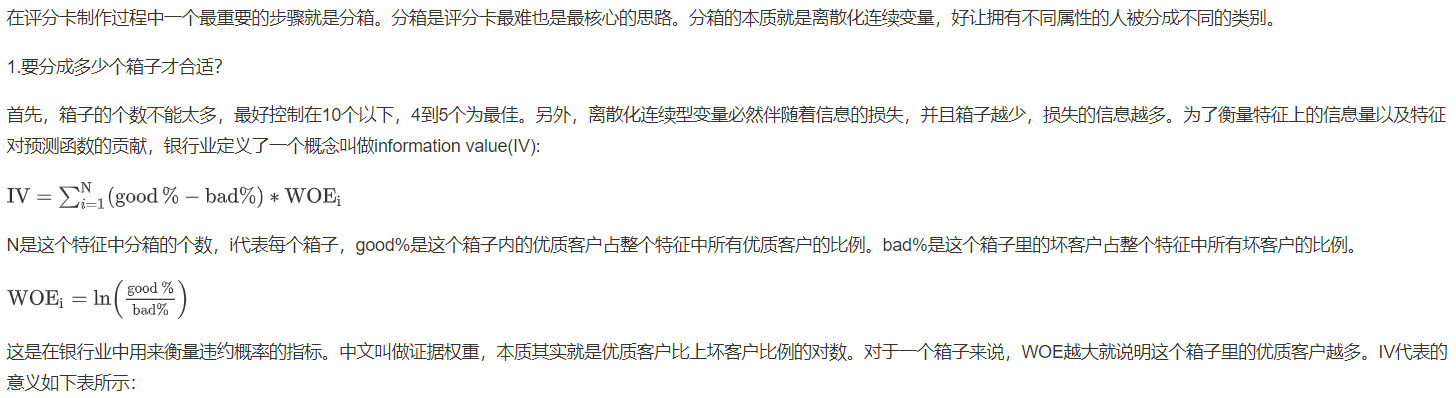

|IV	|特征对预测函数的贡献|
|  ----  | ----  |
|<0.03	|特征几乎不带有效信息，对模型没有贡献，这种特征可以被删除|
|0.03~0.09|	有效信息很少，对模型的贡献度低|
|0.1~0.29	|有效信息一般，对模型的贡献度中等|
|0.3~0.49	|有效信息很多，对模型的贡献度较高|
|>=0.5	|有效信息非常多，对模型贡献超高并且可疑|

我们会对特征进行分箱，然后计算每个箱子数目下的WOE值，利用IV值的曲线，找出合适的分箱个数。

2.分箱要达成什么样的效果？

希望不同属性的人有不同的分数，因此我们希望在同一个箱子内的人的属性是尽量相似的，而不同箱子的人的属性是尽量不同的。即组间差异大，组内差异小。对于评分卡来说，我们希望一个箱子内的人违约概率是类似的，而不同箱子的人违约概率差距很大，并且每个箱子中坏客户占的比重不同。我们可以使用卡方检验来对比两个箱子的相似性。如果两个箱子之间卡方检验的P值很大，则说明他们非常相似，那我们就可以将这两个箱子合并为1个箱子。

3.基于上述的思想，我们总结出对特征进行分箱的步骤：

第一，把连续型变量分成数量较多的分类型变量，比如，将几万个样本分成100组或50组。
第二，确保每一组中都要包含两种类别的样本，否则IV值无法计算。
第三，对相邻的组进行卡方检验，卡方检验的P值很大的组进行合并，直到数据的组数小于设定的N箱为止。
第四，观察不同分箱个数下IV值的变化，找出最合适的分箱个数（在信息损失尽可能小的情况下，减少分箱的个数）。

### 3.1 对特征进行人工等频分箱，然后为每个特征寻找最优区间划分方法

+ Pandas分箱函数
```python
pd.qcut(
  model_data['age'],
  retbins=True,   # 返回每个数对应的分组，且额外返回bins，即每个边界值
  q=20        # integer，指示划分的组数
  )
```

|  参数	|说明  |
|  ----  | ----  |
|x|	ndarray或Series|
|q|	integer，指示划分的组数|
|labels|	array或bool，默认为None。当传入数组时，分组的名称由label指示；当传入Flase时，仅显示分组下标|
|retbins|	bool，是否返回bins，默认为False。当传入True时，额外返回bins，即每个边界值。|
|precision|	int，精度，默认为3|

In [ ]:
model_data['qcut'], updown = pd.qcut(model_data['age'],retbins=True,q=20)

# 对y为0的客户age进行分箱。
count_y0 = model_data[model_data['SeriousDlqin2yrs']==0].groupby(by='qcut').count()['SeriousDlqin2yrs']
# 对y为1的客户age进行分箱。
count_y1 = model_data[model_data['SeriousDlqin2yrs']==1].groupby(by='qcut').count()['SeriousDlqin2yrs']

# *zip 是zip 的反向操作
num_bins = [*zip(updown,updown[1:],count_y0,count_y1)]

columns = ['min','max','count_0','count_1']
df = pd.DataFrame(num_bins,columns=columns)
df.head()

In [ ]:
updown

In [ ]:
updown[1:]

In [ ]:
count_y0

In [ ]:
import scipy
def graph_for_best_bin(DF,X,Y,n=5,q=20,graph=True):
  """
  自动最优分箱函数，基于卡方检验
  
  参数：
  DF:需要输入的数据
  X:需要分箱的列名
  Y:分箱数据对应的标签
  n:保留分箱的个数
  q:初始分箱的个数
  graph:是否要画出IV图像
  
  区间为前开后闭
  
  """
  DF = DF[[X,Y]].copy()
  bins_df = 0
  
  # 先把数据分成q箱
  DF['qcut'], bins = pd.qcut(DF[X],retbins=True,q=q,duplicates='drop')
  count_y0 = model_data[DF[Y]==0].groupby(by='qcut').count()[Y]
  count_y1 = model_data[DF[Y]==1].groupby(by='qcut').count()[Y]
  num_bins = [*zip(bins,bins[1:],count_y0,count_y1)]
  
  # 如果某个箱子里有0，就进行合并。保证每个箱子中正负样本的数量都不为0
  for i in range(q):
    if 0 in num_bins[0][2:]:
      num_bins[0:2] = [(num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
                num_bins[0][3]+num_bins[1][3]
                )]
      continue
          
    for i in range(len(num_bins)):
      if 0 in num_bins[i][2:]:
        num_bins[i-1:i+1] = [(num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3]
                    )]
        break
    else:
      break
  
  # 计算woe函数
  def get_woe(num_bins):
    columns = ['min','max','count_0','count_1']
    df = pd.DataFrame(num_bins,columns=columns)

    df['total'] = df.count_0 + df.count_1   #一个箱中样本的总数量
    df['percentage'] = df.total / df.total.sum()    #一个箱中的样本数占全部样本总数的比例
    df['bad_rate'] = df.count_1 / df.total  
    df['good%'] = df.count_0 / df.count_0.sum()
    df['bad%'] = df.count_1 / df.count_1.sum()
    df['woe'] = np.log(df['good%']/df['bad%'])
    return df
  
  # 计算IV值的函数
  def get_iv(df):
    rate = df['good%'] - df['bad%']
    iv = np.sum(rate * df.woe)
    return iv

  # 利用卡方值合并箱体，合并完毕之后计算woe与IV值。
  IV = []
  axisx = []

  while len(num_bins) > n:
    pvs = []
    # 获得num_bins两两之间的卡方值
    for i in range(len(num_bins)-1):
      x1 = num_bins[i][2:]
      x2 = num_bins[i+1][2:]
      pv = scipy.stats.chi2_contingency([x1,x2])[1]
      pvs.append(pv)

    # 合并p值最大的两组
    i = pvs.index(max(pvs))
    num_bins[i:i+2] = [( num_bins[i][0],
                num_bins[i+1][1],
                num_bins[i][2]+num_bins[i+1][2],
                num_bins[i][3]+num_bins[i+1][3])]
    bins_df = get_woe(num_bins)
    axisx.append(len(num_bins))
    IV.append(get_iv(bins_df))
  
  # 绘图
  if graph:
    plt.figure()
    plt.plot(axisx,IV)

    plt.xticks(axisx)
    plt.xlabel('number of box')
    plt.ylabel('IV value')
    plt.show()

  return bins_df

In [ ]:
for i in model_data.columns[1:-1]:
  print(i)
  graph_for_best_bin(model_data,i,'SeriousDlqin2yrs',n=2,q=20)

+ 能够正常的自动分箱的特征有：
1. RevolvingUtilizationOfUnsecuredLines : 6
2. age : 5
3. DebtRatio : 4
4. MonthlyIncome : 3
5. NumberOfOpenCreditLinesAndLoans : 5


+ 自动分箱存在问题的特征有：
1. NumberOfTime30-59DaysPastDueNotWorse
2. NumberOfTimes90DaysLate
3. NumberRealEstateLoansOrLines
4. NumberOfTime60-89DaysPastDueNotWorse
5. NumberOfDependents

In [ ]:
#对于不能够进行自动分箱的特征，我们需要观察这些特征，手动设置这些特征的区间划分
hand_bins = {
    'NumberOfTime30-59DaysPastDueNotWorse':[0,1,2,13],
    'NumberOfTimes90DaysLate':[0,1,2,17],
    'NumberRealEstateLoansOrLines':[0,1,2,4,54],
    'NumberOfTime60-89DaysPastDueNotWorse':[0,1,2,8],
    'NumberOfDependents':[0,1,2,3]
}

#为了保证区间全覆盖，我们使用np.inf来替换区间的最大值，使用-np.inf来替换区间的最小值
hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

In [ ]:
hand_bins

In [ ]:
# 对于能够使用函数进行自动分箱的特征，我们已经找到了他们的最佳分箱个数
auto_col_bins = {
    'RevolvingUtilizationOfUnsecuredLines':6,
    'age':5,
    'DebtRatio':4,
    'MonthlyIncome':3,
    'NumberOfOpenCreditLinesAndLoans':5
}

# 利用我们找到的最佳分箱个数来找到相应的区间划分
bins_of_col = {}

for col in auto_col_bins:
  bins_df = graph_for_best_bin(model_data,
                col,
                'SeriousDlqin2yrs',
                n=auto_col_bins[col],
                q=20,
                graph=False)
  
  # 将区间上界的集合与区间下界的集合合并，并且按照从小到大进行排序
  bins_list = sorted(set(bins_df['min']).union(bins_df['max']))
  
  # 为保证区间覆盖
  bins_list[0],bins_list[-1] = -np.inf, np.inf
  bins_of_col[col] = bins_list

In [ ]:
# Python字典中的update方法：将字典2中的键值对更新到字典1中
bins_of_col.update(hand_bins)
bins_of_col

### 3.2 利用计算好的区间划分方法为每个特征进行分箱

In [ ]:
#一个新的get_woe函数，用于按照之前的区间划分进行分箱
#为每个分箱计算相应的woe值，用于之后的实际分箱之后的映射
def get_woe(df,col,y,bins):
  df = df[[col,y]].copy()
  df['cut'] = pd.cut(df[col],bins)
  bins_df = df.groupby('cut')[y].value_counts().unstack()
  woe = bins_df['woe'] = np.log((bins_df[0]/bins_df[0].sum()) / (bins_df[1]/bins_df[1].sum()))
  
  return woe

In [ ]:
#将所有特征进行get_woe操作，然后，将计算出的结果存储到一个字典中
woeall = {}
for col in bins_of_col:
  woeall[col] = get_woe(model_data,col,'SeriousDlqin2yrs',bins_of_col[col])

woeall

In [ ]:
# 将所有的woe值映射到原始数据中

# 由于不希望覆盖掉原本的数据，所以我们提前创建一个原始数据索引相同的DataFrame
model_woe = pd.DataFrame(index=model_data.index)

# 对所有特征进行分箱与woe映射操作
for col in bins_of_col:
  model_woe[col] = pd.cut(model_data[col],bins_of_col[col]).map(woeall[col])

In [ ]:
model_woe

In [ ]:
# 将标签补充到数据中
model_woe['SeriousDlqin2yrs'] = model_data['SeriousDlqin2yrs']
model_woe.head()

In [ ]:
# 处理完训练集还要对测试集进行处理
vali_woe = pd.DataFrame(index=vali_data.index)

# 对测试集的所有特征进行分箱与woe映射操作
for col in bins_of_col:
  vali_woe[col] = pd.cut(vali_data[col],bins_of_col[col]).map(woeall[col])

# 将标签补充到数据中
vali_woe['SeriousDlqin2yrs'] = vali_data['SeriousDlqin2yrs']

In [ ]:
vali_woe.head()

## 4.建立模型与模型验证

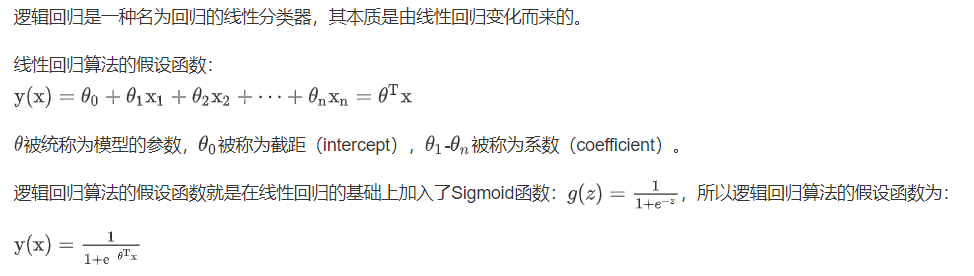

In [ ]:
# 准备训练数据
x = model_woe.iloc[:,:-1]
y = model_woe.iloc[:,-1]

# 准备测试数据
vali_x = vali_woe.iloc[:,:-1]
vali_y = vali_woe.iloc[:,-1]

In [ ]:
# 建立逻辑回归模型
from sklearn.linear_model import LogisticRegression 
lr = LogisticRegression()
lr.fit(x,y)

In [ ]:
# 模型评估--正确率
lr.score(vali_x,vali_y)

In [ ]:
from sklearn.metrics import confusion_matrix

# 混淆矩阵
vali_y_test = lr.predict(vali_x)
confusion_matrix(vali_y,vali_y_test)


In [ ]:
(36936-4912)/36936
(35051-6677)/35051

In [ ]:
# 模型评估--ROC曲线
# import scikitplot as skplt  # 这个包在google colab会出现问题，于是用sklearn替换。
from sklearn.metrics import roc_curve,plot_roc_curve

# 某个标签为正例和负例的概率
# vali_proba_df = pd.DataFrame(lr.predict_proba(vali_x))

# skplt.metrics.plot_roc(vali_y,
#             vali_proba_df,
#             plot_micro=False,
#             figsize=(6,6),
#             plot_macro=False
#             )
display = plot_roc_curve(lr, vali_x, vali_y)
print('type(display):',type(display))
plt.show()


## 5.制作评分卡

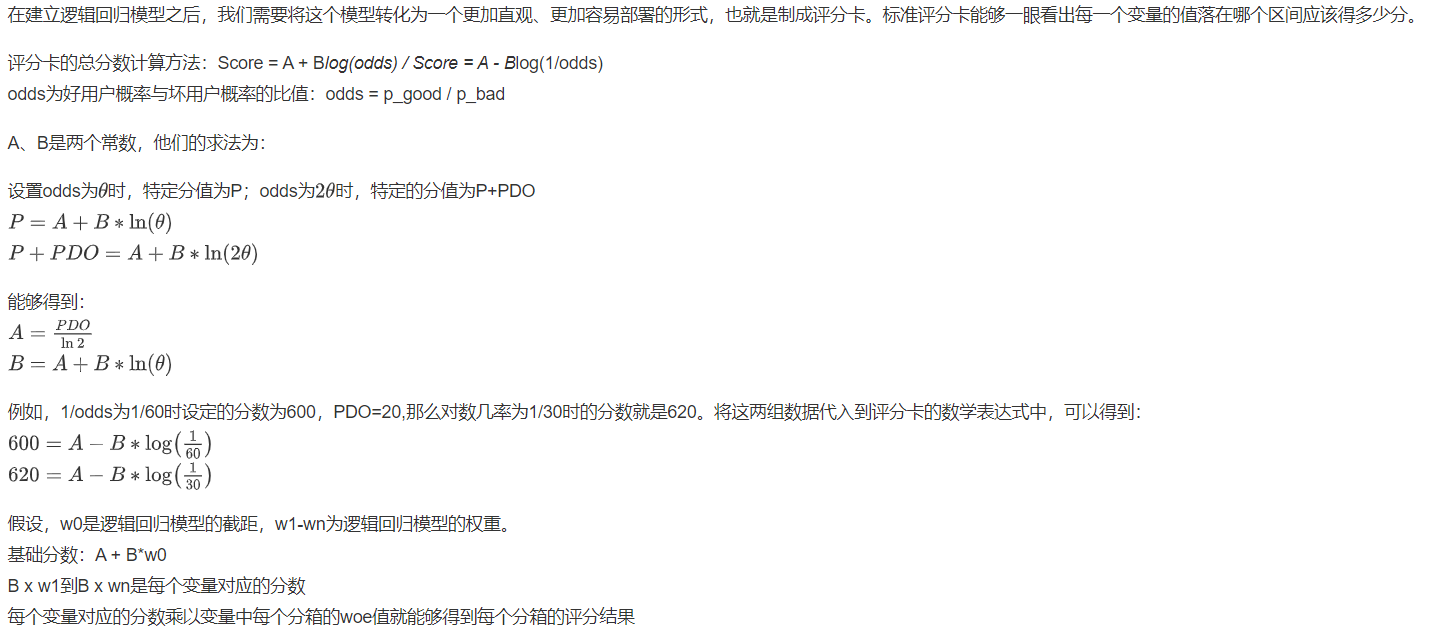

In [ ]:
B = 20 / np.log(2)
A = 600 + B * np.log(1/60)

In [ ]:
# 基础分
base_score = A - B * lr.intercept_
base_score

In [ ]:
# 我们可以通过循环，将所有特征的评分卡内容全部一次性的写入一个本地文件ScoreData.csv


# 将评分结果存入字典
data_dict={}
data_dict['base_score'] = base_score[0]

# file = "/content/ScoreData.csv"
# with open(file,"w") as fdata:
#   fdata.write("base_score,{}\n".format(base_score))



for i,col in enumerate(x.columns):
  score = woeall[col] * (-B*lr.coef_[0][i])
  # score.name = "Score"
  # score.index.name = col
  # score.to_csv(file,header=True,mode="a")
  item = {
      'key':score.index.to_list(),
      'value':score.to_list()
      }
  data_dict[col] = item


# 上面的操作将区放入key中，将区间所对应的值放入value中
print(data_dict['DebtRatio'])
data_dict['base_score']





# 二 、 使用模型对用户进行评分

## 1.评分应用构建

In [ ]:
# 先看一下我们所拥有的资源
data_dict
len(data_dict)

In [ ]:
vali_x
vali_y
len(vali_x.iloc[1,:])

In [ ]:
# 看眼第一行数据形式
vali_x.iloc[1,:]

In [ ]:
# vali_x.iloc[1,:]['RevolvingUtilizationOfUnsecuredLines']

In [ ]:
# 先编写一个测试函数，查看函数是否可行。
def pred_credit_score_test(data):
  score_num = data_dict['base_score']   # 总分
  for index,value in enumerate(data_dict['RevolvingUtilizationOfUnsecuredLines']['key']):
    if data['RevolvingUtilizationOfUnsecuredLines'] in value:
      score_num+=data_dict['RevolvingUtilizationOfUnsecuredLines']['value'][index]
      print(value)
      print(data['RevolvingUtilizationOfUnsecuredLines'])
      print(data_dict['RevolvingUtilizationOfUnsecuredLines']['value'][index])
      break
  print(data_dict['RevolvingUtilizationOfUnsecuredLines'])
pred_credit_score_test(vali_x.iloc[1,:])

+ 可以发现，函数正常运行。第一行是区间。第二行输出是原始数据的值。
+ 可以发现，值在区间内，因此函数正确。第三行是得分。第四行是区间对应得分。全部正确。
+ 开始写完整函数

In [ ]:
# 查看函数是否可行。
def pred_credit_score(data):
  score_num = data_dict['base_score']
  col_name_list = ['RevolvingUtilizationOfUnsecuredLines',
            'age' ,
            'DebtRatio' ,
            'MonthlyIncome' ,
            'NumberOfOpenCreditLinesAndLoans' ,
            'NumberOfTime30-59DaysPastDueNotWorse' ,
            'NumberOfTimes90DaysLate'   ,
            'NumberRealEstateLoansOrLines'     ,
            'NumberOfTime60-89DaysPastDueNotWorse' ,
            'NumberOfDependents']
  for col_name in col_name_list:
    for index,value in enumerate(data_dict[col_name]['key']):
      if data[col_name] in value:
        score_num+=data_dict[col_name]['value'][index]
        break
  return score_num


# 喂入数据进行模拟
# 选取一行数据
user1 = vali_x.iloc[1,:]
user1_score = pred_credit_score(user1)
print(user1)
print('user1信用总分：',user1_score)



## 2.批量运行数据

In [ ]:
# 选取500到1000行的数据进行统计得分。
betch_data1 = vali_x.iloc[500:1000,:]
for i in range(len(betch_data1)):
  item = vali_x.iloc[i,:]
  user_score = pred_credit_score(item)
  print(i,user_score)


# 三 、 持久化模型，方便以后进行使用

## 1.持久化模型

在第一部分，第4小结建立模型时已经对模型进行训练。下面我们把训练好的模型保存到本地，下次训练时加载保存的模型。

In [ ]:
from joblib import dump, load
import os

model = lr
model_path = 'ckpt/lr/'




# 如果路径存在则直接加载模型，如果路径不存在。则训练模型后保存。
if os.path.exists(model_path):
  model = load(model_path+'/lr_ckpt.joblib')
else:
  model.fit(x,y)
  # 已经保存到本地。
  os.makedirs(model_path)
  dump(model,model_path+'/lr_ckpt.joblib')

In [ ]:
model.score(vali_x,vali_y)

## 2.调用持久化模型。

In [ ]:
model2 = LogisticRegression()
model2 = load(model_path+'/lr_ckpt.joblib')
model2.score(vali_x,vali_y)

In [ ]:
plot_roc_curve(model2, vali_x, vali_y)

# 四 、 kaggle上传

## 1.数据读入

In [ ]:
data_kaggle = pd.read_csv(r"../input/GiveMeSomeCredit/cs-test.csv",index_col=0)
data_kaggle.head()

In [ ]:
data_kaggle.isnull().sum()

## 2.缺失值生成

In [ ]:
# 生成缺失值
def fill_data_kaggle(data_df,col_name,target_col):
  known = data_df[data_df[col_name].notnull()]
  unknown = data_df[data_df[col_name].isnull()]

  x_train = known.iloc[:,[1,2,3,4,6,7,8,9]]
  y_train = known.iloc[:,target_col]

  x_test = unknown.iloc[:,[1,2,3,4,6,7,8,9]]

  # 学习器太大比较慢
  clf = RandomForestRegressor(n_estimators=10,random_state=0)

  pred = clf.fit(x_train,y_train)
  pred = clf.predict(x_test)
  return pred

pred_MonthlyIncome_kaggle = fill_data_kaggle(data_kaggle,'MonthlyIncome',5)
pred_NumberOfDependents_kaggle = fill_data_kaggle(data_kaggle,'NumberOfDependents',10)

# 填充缺失值 MonthlyIncome  NumberOfDependents
data_kaggle.loc[data_kaggle['MonthlyIncome'].isnull(),'MonthlyIncome'] = pred_MonthlyIncome_kaggle
data_kaggle.loc[data_kaggle['NumberOfDependents'].isnull(),'NumberOfDependents'] = pred_NumberOfDependents_kaggle


data_kaggle.info()

In [ ]:
data_kaggle.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

## 3.测试数据预处理

In [ ]:
# 处理完训练集还要对测试集进行处理
kaggle_woe =pd.DataFrame()# pd.DataFrame(index=vali_data.index)

# 对测试集的所有特征进行分箱与woe映射操作
for col in bins_of_col:
  kaggle_woe[col] = pd.cut(data_kaggle[col],bins_of_col[col]).map(woeall[col])


kaggle_woe.head()

## 4.预测并填充数据

In [ ]:
kaggle_pred = model2.predict(kaggle_woe)

kaggle_pred[10:20]

In [ ]:
# data_kaggle.loc[data_kaggle['SeriousDlqin2yrs'].isnull(),'SeriousDlqin2yrs']

result_data = data_kaggle.copy()
result_data.loc[result_data['SeriousDlqin2yrs'].isnull(),'SeriousDlqin2yrs'] = kaggle_pred

result_data.iloc[10:20,:]

In [ ]:
result_data.to_csv('result_data.csv')

# ../input/GiveMeSomeCredit/cs-training.csv

In [ ]:
result = result_data.iloc[:,0]

result.name = 'Probability'

# rename(column={'SeriousDlqin2yrs':'Probability'},inplace=True)

result

result.to_csv('result_data2.csv',index_label='Id')